In [1]:
import os
import gc
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch import optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split


from transformers import BertForSequenceClassification
from transformers import AutoModelForSequenceClassification, DistilBertModel, AutoModel
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
import evaluate
import warnings  

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

/home/maxim/anaconda3/envs/bert_clasify/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_random_seed(seed):
    """
    Set the random seed for NumPy and PyTorch.
    Parameters:
    seed (int): The seed value to set for random number generation.
    """
    np.random.seed(seed)  # Set seed for NumPy
    torch.manual_seed(seed)  # Set seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Set seed for GPU
        torch.cuda.manual_seed_all(seed) #Set for all GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_random_seed(42)

In [3]:
reddit_df_title = pd.read_csv('data/stress-detection-from-social-media-articles/Reddit_Title.csv', sep=";")
reddit_df_title = reddit_df_title.drop(columns = ['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'])

In [4]:
reddit_df_title.label.value_counts()

label
0    2811
1    2745
Name: count, dtype: int64

In [5]:
train_df, test_df = train_test_split(reddit_df_title, test_size = 0.3, shuffle = True)

In [6]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text = df.title.values
        self.labels = df.label.values
    def __getitem__(self, idx):
        one2two = np.eye(2)
        dict_idx = self.tokenizer(self.text[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        dict_idx['labels'] = one2two[self.labels[[idx]]]
        return dict_idx
    def __len__(self):return self.text.shape[0]


In [7]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

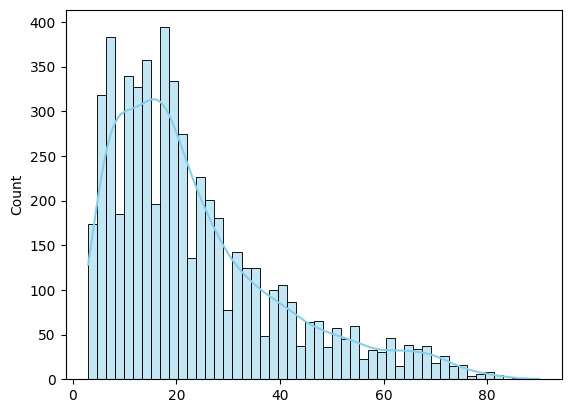

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


lens = list(map(len, tokenizer(list(reddit_df_title['title'].values))['input_ids']))
hist = sns.histplot(lens, 
                    bins=50, 
                    color='skyblue', 
                    edgecolor='black', 
                    kde=True)
plt.show()


In [9]:
max_length = 80

train_dataset = TextDataset(train_df, tokenizer = tokenizer, max_length = max_length)
test_dataset = TextDataset(test_df,tokenizer = tokenizer, max_length = max_length)

In [10]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size, shuffle = True, num_workers=4)


In [11]:
class CosineLearningRate():
    def __init__(self, max_lr, min_lr, warmupsteps, max_steps):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmupsteps = warmupsteps
        self.max_steps = max_steps
    
    def get_lr(self, it):
        if it < self.warmupsteps:
            return self.max_lr * (it + 1)
        if it > self.max_steps:
            return self.min_lr
        decay_ratio = (it - self.warmupsteps) / (self.max_steps - self.warmupsteps)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_lr + coeff * (self.max_lr - self.min_lr)
        
class DistilBertModelClass(torch.nn.Module):
    def __init__(self, d_model, nclasses, dropout = .4):
        super(DistilBertModelClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(d_model, nclasses)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1['last_hidden_state']
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [21]:
model = DistilBertModelClass(d_model = 768, nclasses=2).to(device)
# model = torch.nn.DataParallel(model, device_ids = [0,1])

In [17]:
def accuracy(preds, targets):
    a = preds.argmax(dim = 1) == targets.argmax(dim = 1)
    return(a.sum() / a.shape[0])

In [22]:
from tqdm import tqdm
import time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 2e-5)
epochs = 50
train_loss_per_epoch = np.zeros(epochs)
val_loss_per_epoch = np.zeros(epochs)
val_acc_per_epoch = np.zeros(epochs)
best_train_loss = float('inf')
best_val_loss = float('inf')
tolerance = 0.001
early_stop_steps = 5
c = 0
for epoch in tqdm(range(epochs), desc ="Epoch"):
    train_losses = []
    val_losses = []
    acc = []
    model.train()
    for d in train_loader:
        optimizer.zero_grad()
        x = d['input_ids'].to(device)
        mask = d['attention_mask'].to(device)
        y = d['labels'].to(device, dtype = torch.float32).squeeze(1)
        with torch.autocast(device_type=device.type, dtype = torch.bfloat16):
            preds = model(x.squeeze(1), mask.squeeze(1))
            loss = loss_fn(preds, y)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for d in test_loader:
            x = d['input_ids'].to(device)
            mask = d['attention_mask'].to(device)
            y = d['labels'].to(device, dtype = torch.float32).squeeze(1)
            with torch.autocast(device_type=device.type, dtype = torch.bfloat16):
                preds = model(x.squeeze(1), mask.squeeze(1))
                loss = loss_fn(preds, y)
            val_losses.append(loss.item())
            acc.append(accuracy(F.softmax(preds, dim = 1), y).item())
            
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_acc = sum(acc) / len(acc)
    train_loss_per_epoch[epoch] = avg_train_loss
    val_loss_per_epoch[epoch] = avg_val_loss
    val_acc_per_epoch[epoch] = avg_val_acc
    if epoch % 1 == 0:
        print(f"Train loss: {avg_train_loss:.4f}; Validation loss: {avg_val_loss:.4f}; Validation acc: {avg_val_acc:.4f}")
    if (avg_train_loss < best_train_loss) and (avg_val_loss < best_val_loss):
        best_train_loss = avg_train_loss
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'model_veights_{epoch}epo.pt')
    if -tolerance <= train_loss_per_epoch[max(0, epoch-1)] - train_loss_per_epoch[epoch] <= tolerance:
        c +=1
    else:
        c = 0
    if c == early_stop_steps:
        break


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.5666; Validation loss: 0.3169; Validation acc: 0.9348


Epoch:   2%|▏         | 1/50 [00:07<05:44,  7.02s/it]

Train loss: 0.2148; Validation loss: 0.1600; Validation acc: 0.9455


Epoch:   4%|▍         | 2/50 [00:13<05:35,  6.99s/it]

Train loss: 0.1080; Validation loss: 0.1327; Validation acc: 0.9566


Epoch:   8%|▊         | 4/50 [00:27<05:12,  6.80s/it]

Train loss: 0.0738; Validation loss: 0.1337; Validation acc: 0.9582


Epoch:  10%|█         | 5/50 [00:33<05:01,  6.69s/it]

Train loss: 0.0488; Validation loss: 0.1489; Validation acc: 0.9511


Epoch:  12%|█▏        | 6/50 [00:40<04:51,  6.63s/it]

Train loss: 0.0348; Validation loss: 0.1558; Validation acc: 0.9567


Epoch:  14%|█▍        | 7/50 [00:47<04:43,  6.59s/it]

Train loss: 0.0247; Validation loss: 0.1563; Validation acc: 0.9561


Epoch:  16%|█▌        | 8/50 [00:53<04:36,  6.58s/it]

Train loss: 0.0210; Validation loss: 0.1714; Validation acc: 0.9543


Epoch:  18%|█▊        | 9/50 [01:00<04:29,  6.56s/it]

Train loss: 0.0171; Validation loss: 0.1964; Validation acc: 0.9510


Epoch:  20%|██        | 10/50 [01:06<04:22,  6.55s/it]

Train loss: 0.0178; Validation loss: 0.2036; Validation acc: 0.9509


Epoch:  22%|██▏       | 11/50 [01:13<04:15,  6.54s/it]

Train loss: 0.0207; Validation loss: 0.2046; Validation acc: 0.9533


Epoch:  24%|██▍       | 12/50 [01:19<04:08,  6.54s/it]

Train loss: 0.0148; Validation loss: 0.1861; Validation acc: 0.9533


Epoch:  26%|██▌       | 13/50 [01:26<04:01,  6.53s/it]

Train loss: 0.0121; Validation loss: 0.1811; Validation acc: 0.9554


Epoch:  28%|██▊       | 14/50 [01:32<03:54,  6.52s/it]

Train loss: 0.0124; Validation loss: 0.1858; Validation acc: 0.9539


Epoch:  30%|███       | 15/50 [01:39<03:48,  6.52s/it]

Train loss: 0.0105; Validation loss: 0.2064; Validation acc: 0.9532


Epoch:  32%|███▏      | 16/50 [01:45<03:42,  6.54s/it]

Train loss: 0.0075; Validation loss: 0.1916; Validation acc: 0.9550


Epoch:  34%|███▍      | 17/50 [01:52<03:35,  6.54s/it]

Train loss: 0.0071; Validation loss: 0.2047; Validation acc: 0.9550


Epoch:  34%|███▍      | 17/50 [01:55<03:44,  6.81s/it]


KeyboardInterrupt: 